In [1]:
import pandas as pd 
import numpy as np
#tdqm = progress bar
from tqdm import tqdm
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Number of rows
nrows = 10000
# Chunksize = 10000 
chunksize = 10000
# Vitou's path
path = 'C:/Users/sirus/Downloads/train.csv'
# Muna's path
#path = '/Users/muna/Development/DataScience/new-york-city-taxi-fare-prediction/train.csv'
# Columns to read from the data
# Todo :split date into meaningful data
# cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','fare_amount']
cols = ['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','fare_amount']

#list to hold the batch dataframe
df_list = []

for df_chunk in tqdm(pd.read_csv(path,usecols=cols, chunksize=chunksize,nrows=nrows)):
    df_list.append(df_chunk)
    
# Merge all dataframes into one dataframe
data = pd.DataFrame()
data = pd.concat(df_list)
# # Delete the dataframe list to release memory
del df_list, df_chunk

1it [00:00, 50.13it/s]


### Let's take a look at the data

In [3]:
%%time
data.describe(include='all')

Wall time: 26.2 ms


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
unique,NaN,9985,NaN,NaN,NaN,NaN,NaN
top,NaN,2012-12-06 18:05:00 UTC,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,NaN,NaN,NaN,NaN
mean,11.235464,NaN,-72.466660,39.920448,-72.474094,39.893281,1.644700
std,9.584258,NaN,10.609729,7.318932,10.579732,6.339919,1.271229
min,-2.900000,NaN,-74.438233,-74.006893,-74.429332,-73.994392,0.000000
25%,6.000000,NaN,-73.992058,40.734547,-73.991112,40.735230,1.000000
50%,8.500000,NaN,-73.981758,40.752693,-73.980083,40.753738,1.000000
75%,12.500000,NaN,-73.966925,40.767694,-73.963504,40.768186,2.000000


### Check for missing values

In [4]:
%%time
# Checking for missing values
data.isnull().sum()

Wall time: 3.99 ms


fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### From our observation, there are some missing values, so we remove them

In [5]:
%%time
data = data.dropna(how = 'any', axis = 'rows')

Wall time: 4.97 ms


### Let's take a look at the data

In [6]:
data['fare_amount'].describe()

count    10000.000000
mean        11.235464
std          9.584258
min         -2.900000
25%          6.000000
50%          8.500000
75%         12.500000
max        180.000000
Name: fare_amount, dtype: float64

### From the description above, some of the fare_amount have negative values

We are going to remove all negatvie fare_amounts

In [7]:
%%time
data = data[(data['fare_amount'] > 0)]

Wall time: 2 ms


### Let's take a detailed look at the passenger count

In [8]:
data['passenger_count'].describe()

count    9998.000000
mean        1.644829
std         1.271324
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

The highest passenger count per taxi ride is 208, which is not possible. So we remove all passenger_count grater than 6, since 6 is the maximum passenger capacity for Uber/Lyft if the ride is an SUV

In [9]:
data = data[(data['passenger_count'] <= 6)]

In [10]:
data['passenger_count'].describe()

count    9998.000000
mean        1.644829
std         1.271324
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

Now the highest passenger capacity is 6

### Looking at the pickup|droppoff latitudes and longitudes

In [11]:
data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,9998.000000,9998.000000,9998.000000,9998.000000
mean,39.920296,-72.466375,39.893123,-72.473810
std,7.319656,10.610771,6.340543,10.580772
min,-74.006893,-74.438233,-73.994392,-74.429332
25%,40.734564,-73.992056,40.735235,-73.991109
50%,40.752695,-73.981758,40.753740,-73.980083
75%,40.767696,-73.966934,40.768187,-73.963512
max,401.083332,40.766125,41.366138,40.802437


Looking at the info above, the maximum pickup_latitude/pickup_longtide/droppoff_latitude/dropoff_longitude are over 3000 white their respective minimum values are over -3000

Latitudes range from -90 to 90 while longitudes range from -180 to 180, for single degree format. So we remove all values that are not with the latitude and longitude ranges

In [12]:
data = data.drop((data[(data['pickup_latitude'] > 90) | (data['pickup_latitude'] < -90)]).index, axis=0)

In [13]:
data = data.drop((data[(data['pickup_longitude'] > 180) | (data['pickup_longitude'] < -180)]).index, axis=0)

We will do the same for dropoff cordinates

In [14]:
data = data.drop((data[(data['dropoff_latitude'] > 90) | (data['dropoff_latitude'] < -90)]).index, axis=0)

In [15]:
data = data.drop((data[(data['dropoff_longitude'] > 180) | (data['dropoff_longitude'] < -180)]).index, axis=0)

In [16]:
data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,9997.000000,9997.000000,9997.000000,9997.000000
mean,39.884169,-72.466227,39.893035,-72.473662
std,6.366501,10.611292,6.340854,10.581290
min,-74.006893,-74.438233,-73.994392,-74.429332
25%,40.734562,-73.992057,40.735233,-73.991112
50%,40.752694,-73.981762,40.753740,-73.980087
75%,40.767693,-73.966957,40.768185,-73.963527
max,41.366138,40.766125,41.366138,40.802437


### Feature Engineering

In [17]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(data)

### In further observation, we have pickup_longitude, puckup_latitiude, dropoff_longitude and dropoff_latitude. We can calculate the distance

In [18]:
# Function that calculates distance between pickup location and dropoff location
def getDistance(lat1,lon1,lat2,lon2):
    r = 6378 # earth's radius
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = r*c
    
    return distance



In [19]:
%%time
# Add new cloumn "distance" to the data
data['distance'] = getDistance(data.pickup_latitude, data.pickup_longitude, 
                                      data.dropoff_latitude, data.dropoff_longitude)

Wall time: 6.98 ms


In [20]:
%%time
print(data[::10])

      fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0            4.50  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
10           5.30  2012-04-08 07:30:50 UTC        -73.996335        40.737142   
20          10.50  2010-09-07 13:18:00 UTC        -73.985382        40.747858   
30           5.50  2014-02-19 16:03:00 UTC        -73.976075        40.752422   
40           8.10  2011-03-29 15:39:49 UTC        -73.984267        40.744961   
50           9.70  2011-12-06 09:09:21 UTC        -73.985582        40.739765   
60           5.00  2014-07-16 10:57:00 UTC        -73.996148        40.741890   
70           6.90  2009-08-02 02:34:11 UTC        -73.995781        40.723411   
80           5.70  2010-08-19 16:33:00 UTC        -73.973830        40.763717   
90          10.50  2010-04-27 21:40:07 UTC        -74.001135        40.730979   
100         10.00  2014-11-12 12:40:29 UTC        -74.002581        40.739572   
110          9.00  2014-05-2

[1000 rows x 10 columns]
Wall time: 16 ms


### Creating new features like year, month, day, hour and dayOfWeek from pickup_datetime

In [21]:
def split_datetime(df):
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
        df['year'] = df['pickup_datetime'].dt.year
        df['month'] = df['pickup_datetime'].dt.month
        df['day'] = df['pickup_datetime'].dt.day
        df['hour'] = df['pickup_datetime'].dt.hour
        df['dayOfWeek'] = df['pickup_datetime'].dt.dayofweek
        
        return df

In [22]:
%%time
split_datetime(data)

Wall time: 48.9 ms


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,1.031896,2009,6,15,17,0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,8.459418,2010,1,5,16,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,1.391052,2011,8,18,0,3
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2.802346,2012,4,21,4,5
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2.001353,2010,3,9,7,1
5,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,0.028072,0.026603,3.791400,2011,1,6,9,3
6,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,0.006200,0.013180,1.557516,2012,11,20,20,1
7,16.5,2012-01-04 17:22:00,-73.951300,40.774138,-73.990095,40.751048,1,0.038795,0.023090,4.160010,2012,1,4,17,2
8,9.0,2012-12-03 13:10:00,-74.006462,40.726713,-73.993078,40.731628,1,0.013384,0.004915,1.254608,2012,12,3,13,0
9,8.9,2009-09-02 01:11:00,-73.980658,40.733873,-73.991540,40.758138,2,0.010882,0.024265,2.852758,2009,9,2,1,2


Now that we have split pickup_datetime into year, month, day, hour and year

### Let's take a look at hour adn dayOfWeek

In [23]:
%%time
data['hour'].describe()

Wall time: 5.02 ms


count    9997.000000
mean       13.506152
std         6.515771
min         0.000000
25%         9.000000
50%        14.000000
75%        19.000000
max        23.000000
Name: hour, dtype: float64

According to New York Times, rush hours is ususally between 7 to 9AM and from 4 to 6PM. Let's create a new feature from hour

In [24]:
def rush_hour(hour):
    if hour in range(7, 10) or hour in range(4, 7):
        return 1
    else:
        return 0

In [25]:
%%time
data['rush_hour'] = data['hour'].apply(rush_hour)

Wall time: 9.97 ms


In [26]:
%%time
data['dayOfWeek'].describe()

Wall time: 3.99 ms


count    9997.000000
mean        3.024807
std         1.972496
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max         6.000000
Name: dayOfWeek, dtype: float64

We can also create a new feature from daysOfWeek. We can check if it's a weekend or not

In [27]:
def weekend(dayOfWeek):
    if dayOfWeek == 0 or dayOfWeek == 6:
        return 1
    else:
        return 0

In [28]:
%%time
data['weekend'] = data['dayOfWeek'].apply(weekend)

Wall time: 3.99 ms


In [29]:
print(data[::10])

      fare_amount     pickup_datetime  pickup_longitude  pickup_latitude  \
0            4.50 2009-06-15 17:26:21        -73.844311        40.721319   
10           5.30 2012-04-08 07:30:50        -73.996335        40.737142   
20          10.50 2010-09-07 13:18:00        -73.985382        40.747858   
30           5.50 2014-02-19 16:03:00        -73.976075        40.752422   
40           8.10 2011-03-29 15:39:49        -73.984267        40.744961   
50           9.70 2011-12-06 09:09:21        -73.985582        40.739765   
60           5.00 2014-07-16 10:57:00        -73.996148        40.741890   
70           6.90 2009-08-02 02:34:11        -73.995781        40.723411   
80           5.70 2010-08-19 16:33:00        -73.973830        40.763717   
90          10.50 2010-04-27 21:40:07        -74.001135        40.730979   
100         10.00 2014-11-12 12:40:29        -74.002581        40.739572   
110          9.00 2014-05-22 18:30:00        -73.982272        40.748357   
120         

[1000 rows x 17 columns]


In [30]:
# sns.barplot(x=data['year'],y=data["fare_amount"],data=data).set_title("Fare Amount over Years")

### Looks like fares have been incrasing over the years

In [31]:
# sns.barplot(x=data['hour'],y=data["fare_amount"],data=data).set_title("Pickup hour vs fare amount")

#### The fare amount is highest around 5am

In [32]:
# sns.barplot(x=data['dayOfWeek'],y=data["fare_amount"],data=data).set_title("Pickup days vs fare amount")

### Correlation between features/variables

In [33]:
# %%time
# correlation= data.corr()
# colormap = plt.cm.inferno
# mask = np.array(correlation)
# mask[np.tril_indices_from(mask)] = False
# fig=plt.gcf()
# fig.set_size_inches(30,12)
# sns.heatmap(data=correlation ,mask=mask,square=True,annot=True,cbar=True,cmap=colormap, linecolor='White', linewidths=0.1)

In [34]:
def get_input_matrix(df):
    return np.column_stack((df.pickup_longitude,df.pickup_latitude,df.dropoff_longitude,
                            df.dropoff_latitude,df.passenger_count,df.year,df.month,
                            df.day,df.hour,df.dayOfWeek, df.distance, df.abs_diff_longitude,
                            df.abs_diff_latitude, df.rush_hour,df.weekend, np.ones(len(df))))

In [35]:
%%time
X = get_input_matrix(data)
y = np.array(data['fare_amount'])

Wall time: 3 ms


In [36]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=2)

Wall time: 2.99 ms


In [37]:
%%time
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_encoded = lab_enc.fit_transform(y)
y_test_encoded = lab_enc.fit_transform(y_test)

Wall time: 2.99 ms


### Regressions

In [38]:
%%time
my_linreg = LinearRegression(n_jobs=-1)
my_linreg.fit(X_train, y_train)
y_prediction_lr = my_linreg.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_prediction_lr)
rmse_lr = np.sqrt(mse)
print('Linear Regression:'+str(rmse_lr))

Linear Regression:9.365704524765738
Wall time: 437 ms


In [39]:
%%time
#max_iter default = 100
my_logreg = LogisticRegression(max_iter=100,solver='sag',multi_class='auto')
my_logreg.fit(X_train, y_train_encoded)
y_prediction_log = my_logreg.predict(X_test)
mse_log = metrics.mean_squared_error(y_test, y_prediction_log)
rmse_log = np.sqrt(mse_log)
print('Logistic Regression: '+str(rmse_log))

C:\Users\sirus\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression: 15.958867445195894
Wall time: 14.6 s


In [40]:
%%time

my_rfr = RandomForestRegressor(n_estimators = 10, bootstrap=True, random_state=3)
my_rfr.fit(X_train, y_train)
y_prediction_rfr = my_rfr.predict(X_test)
mse_rfr = metrics.mean_squared_error(y_test, y_prediction_rfr)
rmse_rfr = np.sqrt(mse_rfr)
print('Random Forest Regressor: '+str(rmse_rfr))

Random Forest Regressor: 4.789684228735752
Wall time: 640 ms


### Corss Validation

In [41]:
%%time
score_list_lr = cross_val_score(my_linreg, X, y, cv=10)
score_lr = abs(score_list_lr).mean()
print('Linear Regression: '+str(score_lr))

Linear Regression: 21.396116037170785
Wall time: 76.3 ms


In [42]:
%%time
score_list = cross_val_score(my_logreg, X, y_encoded, cv=10)
score_log = score_list.mean()
print('Logistic Regression: '+str(score_log))

C:\Users\sirus\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\sirus\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sirus\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sirus\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\sirus\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: Convergen

Logistic Regression: 0.0477386893175749
Wall time: 3min 39s


In [43]:
%%time
score_list = cross_val_score(my_rfr, X, y, cv=10)
score_rfr = score_list.mean()
print('Logistic Regression: '+str(score_rfr))

Logistic Regression: 0.7374283829317648
Wall time: 8.39 s


## Plots

In [44]:
y_predict_prob_log = my_logreg.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test_encoded, y_predict_prob_log[:,1], pos_label=1)

print(fpr)
print(tpr)

[0.00000000e+00 3.34001336e-04 8.45023380e-02 8.45023380e-02
 1.59652639e-01 1.59652639e-01 2.97595190e-01 2.97595190e-01
 5.64796259e-01 5.64796259e-01 8.00267201e-01 8.00267201e-01
 9.07815631e-01 9.07815631e-01 1.00000000e+00]
[0.         0.         0.         0.16666667 0.16666667 0.33333333
 0.33333333 0.5        0.5        0.66666667 0.66666667 0.83333333
 0.83333333 1.         1.        ]


In [45]:
# AUC:
AUC = metrics.auc(fpr, tpr)
print(AUC)

0.5308951235804943


### ROC Curve

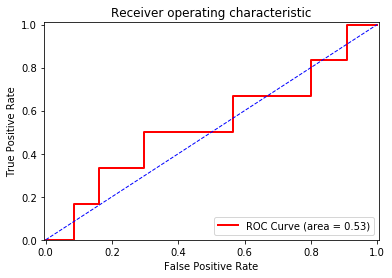

In [46]:
# The following line will tell Jupyter Notebook to keep the figures inside the explorer page 
# rather than openng a new figure window:
%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

### RSME Plot

Text(0.5, 1.0, 'RMSE Values')

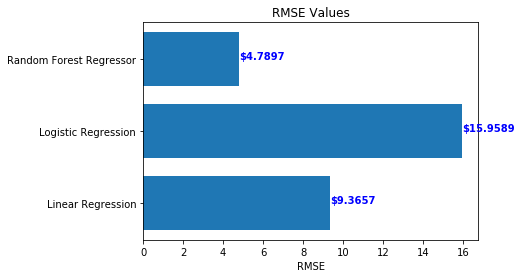

In [47]:
fig, ax = plt.subplots()
y_axis = ('Linear Regression','Logistic Regression','Random Forest Regressor')
y_pos = np.arange(len(y_axis))
width = 0.75 
x_axis = (round(rmse_lr,4),round(rmse_log,4),round(rmse_rfr,4))
ax.barh(y_pos, x_axis, width,align='center')
for i, v in enumerate(x_axis):
    ax.text(v, i, '$'+str(v), color='blue', fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_axis)
ax.set_xlabel('RMSE')
ax.set_title('RMSE Values')

### Cross Validation Plot

Text(0.5, 1.0, 'Cross Validation Values')

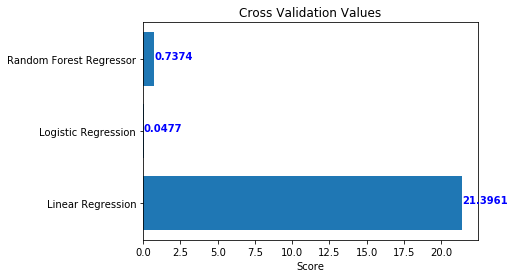

In [48]:
fig, ax = plt.subplots()
y_axis = ('Linear Regression','Logistic Regression','Random Forest Regressor')
y_pos = np.arange(len(y_axis)) 
x_axis = (round(score_lr,4),round(score_log,4),round(score_rfr,4))
ax.barh(y_pos, x_axis, width,align='center')
for i, v in enumerate(x_axis):
    ax.text(v, i, str(v), color='blue', fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_axis)
ax.set_xlabel('Score')
ax.set_title('Cross Validation Values')